In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from PIL import Image as img
from skimage.color import rgb2gray
from skimage.io import imread, imshow, show
from skimage.transform import rescale, resize
import cv2 as cv

from scipy import signal

import numpy.fft as fp

# To do
- Buktikan bahwa konvulusi sama dengan korelasi yang kernelnya diputar 180 derajat
- Buatlah script perhitungan konvolusi secara langsung dan konvolusi dengan transformasi Fourier! Hitung waktu running untuk masing-masing proses konvolusi.

# Load Image

In [2]:
image1 = imread('/kaggle/input/image-test-fft/Sekiro Photo Manipulation.png')
image2 = imread('/kaggle/input/image-test-fft/smirk.jpg')
image1_open = img.open('/kaggle/input/image-test-fft/Sekiro Photo Manipulation.png')
image2_open = img.open('/kaggle/input/image-test-fft/smirk.jpg')

In [3]:
image_res = resize(image1,(108,192)) 
image_255 = image_res * 255
image1 = image_255.astype(np.uint8) 

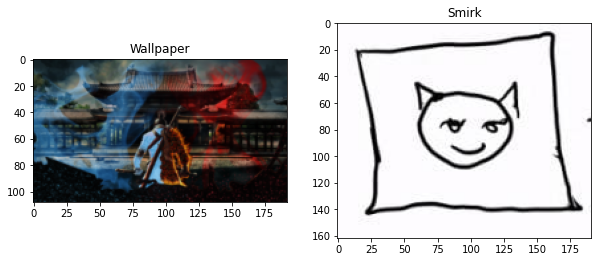

In [4]:
plt.figure(figsize=(10,12))
plt.subplot(1,2,1)
plt.title('Wallpaper')
plt.imshow(image1)
plt.subplot(1,2,2)
plt.title('Smirk')
plt.imshow(image2)

In [5]:
im1 = rgb2gray(image1)
im2 = rgb2gray(image2)

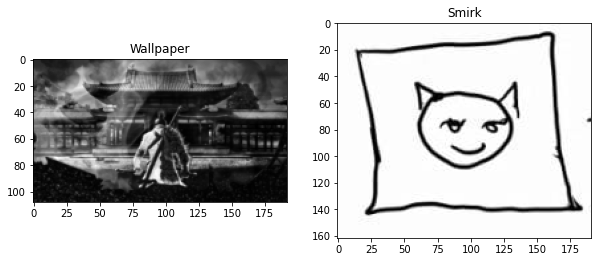

In [6]:
plt.figure(figsize=(10,12))
plt.subplot(1,2,1)
plt.title('Wallpaper')
plt.imshow(im1, cmap='gray')
plt.subplot(1,2,2)
plt.title('Smirk')
plt.imshow(im2, cmap='gray')

# Kernel Box Blur, Laplace Edge, Edge Detect

In [7]:
blur_box_kernel = np.ones((3,3)) / 9
edge_laplace_kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
gauss_blur = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/ 16

# Correlation vs Convolution

In [8]:
im_cor1 = signal.correlate2d(im1, edge_laplace_kernel)
im_conv1 = signal.convolve2d(im1, edge_laplace_kernel)
im_cor2 = signal.correlate2d(im2, edge_laplace_kernel)
im_conv2 = signal.convolve2d(im2, edge_laplace_kernel)

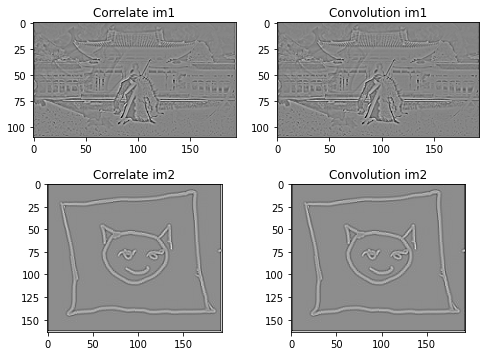

In [9]:
plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.title('Correlate im1')
plt.imshow(im_cor1, cmap='gray')
plt.subplot(2,2,2)
plt.title('Convolution im1')
plt.imshow(im_conv1, cmap='gray')
plt.subplot(2,2,3)
plt.title('Correlate im2')
plt.imshow(im_cor2, cmap='gray')
plt.subplot(2,2,4)
plt.title('Convolution im2')
plt.imshow(im_conv2, cmap='gray')

# Convolution Manual, FFT, Scipy-Signal

## Eksekusi Kernel Manual

In [10]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

In [11]:
%%time
a = 0
b = 1
im_man_box1 = convolve2D(im1, blur_box_kernel, padding = a, strides = b)
im_man_lap1 = convolve2D(im1, edge_laplace_kernel, padding = a, strides = b)
im_man_gauss1 = convolve2D(im1, gauss_blur, padding = a, strides = b)

im_man_box2 = convolve2D(im2, blur_box_kernel, padding = a, strides = b)
im_man_lap2 = convolve2D(im2, edge_laplace_kernel, padding = a, strides = b)
im_man_gauss2 = convolve2D(im2, gauss_blur, padding = a, strides = b)

CPU times: user 645 ms, sys: 0 ns, total: 645 ms
Wall time: 646 ms


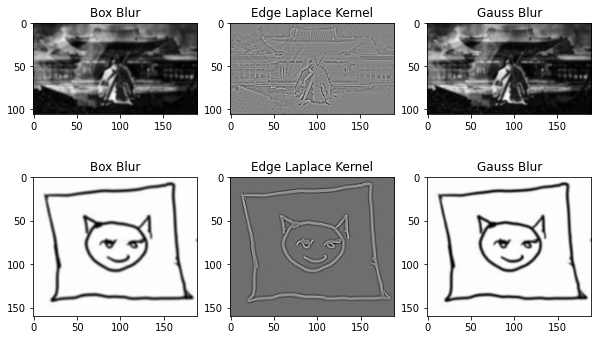

In [12]:
plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
plt.title('Box Blur')
plt.imshow(im_man_box1, cmap='gray')
plt.subplot(2,3,2)
plt.title('Edge Laplace Kernel')
plt.imshow(im_man_lap1, cmap='gray')
plt.subplot(2,3,3)
plt.title('Gauss Blur')
plt.imshow(im_man_gauss1, cmap='gray')
plt.subplot(2,3,4)
plt.title('Box Blur')
plt.imshow(im_man_box2, cmap='gray')
plt.subplot(2,3,5)
plt.title('Edge Laplace Kernel')
plt.imshow(im_man_lap2, cmap='gray')
plt.subplot(2,3,6)
plt.title('Gauss Blur')
plt.imshow(im_man_gauss2, cmap='gray')

## Eksekusi Kernel dengan FFT

In [13]:
def conv_fft(x,y):
    # x = image, y = kernel
    s1 = np.array(x.shape)
    s2 = np.array(y.shape)

    size = s1 + s2 - 1

    fsize = 2 ** np.ceil(np.log2(size)).astype(int)
    fslice = tuple([slice(0, int(sz)) for sz in size])

    new_x = np.fft.fft2(x , fsize)
    new_y = np.fft.fft2(y , fsize)
    
    result = np.fft.ifft2(new_x*new_y)[fslice].copy()
    
    return np.absolute(result)

In [14]:
%%time
im_fft_box1 = conv_fft(im1, blur_box_kernel)
im_fft_lap1 = conv_fft(im1, edge_laplace_kernel)
im_fft_gauss1 = conv_fft(im1, gauss_blur)

im_fft_box2 = conv_fft(im2, blur_box_kernel)
im_fft_lap2 = conv_fft(im2, edge_laplace_kernel)
im_fft_gauss2 = conv_fft(im2, gauss_blur)

CPU times: user 22.9 ms, sys: 3.66 ms, total: 26.6 ms
Wall time: 26.2 ms


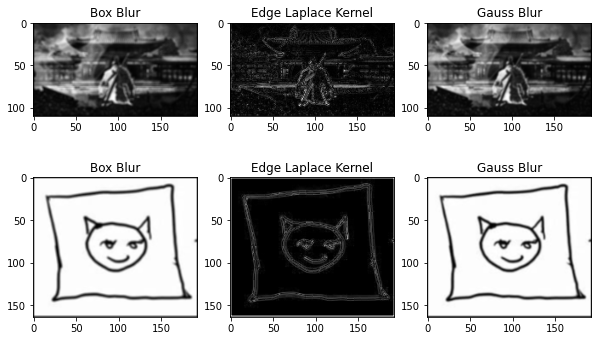

In [15]:
plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
plt.title('Box Blur')
plt.imshow(im_fft_box1, cmap='gray')
plt.subplot(2,3,2)
plt.title('Edge Laplace Kernel')
plt.imshow(im_fft_lap1, cmap='gray')
plt.subplot(2,3,3)
plt.title('Gauss Blur')
plt.imshow(im_fft_gauss1, cmap='gray')
plt.subplot(2,3,4)
plt.title('Box Blur')
plt.imshow(im_fft_box2, cmap='gray')
plt.subplot(2,3,5)
plt.title('Edge Laplace Kernel')
plt.imshow(im_fft_lap2, cmap='gray')
plt.subplot(2,3,6)
plt.title('Gauss Blur')
plt.imshow(im_fft_gauss2, cmap='gray')

## Eksekusi Kernel dengan Scipy Signal

In [16]:
%%time
im_blurred1 = signal.convolve2d(im1, blur_box_kernel)
im_lap1 = np.clip(signal.convolve2d(im1, edge_laplace_kernel), 0, 1)
im_gauss1 = np.clip(signal.convolve2d(im1, gauss_blur), 0, 1)
im_blurred2 = signal.convolve2d(im2, blur_box_kernel)
im_lap2 = np.clip(signal.convolve2d(im2, edge_laplace_kernel), 0, 1)
im_gauss2 = np.clip(signal.convolve2d(im2, gauss_blur), 0, 1)

CPU times: user 9 ms, sys: 2.02 ms, total: 11 ms
Wall time: 10.3 ms


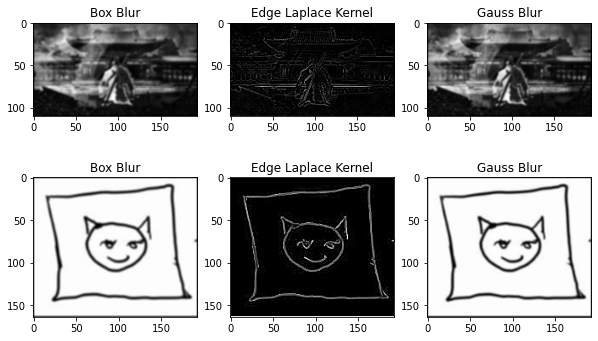

In [17]:
plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
plt.title('Box Blur')
plt.imshow(im_blurred1, cmap='gray')
plt.subplot(2,3,2)
plt.title('Edge Laplace Kernel')
plt.imshow(im_lap1, cmap='gray')
plt.subplot(2,3,3)
plt.title('Gauss Blur')
plt.imshow(im_gauss1, cmap='gray')
plt.subplot(2,3,4)
plt.title('Box Blur')
plt.imshow(im_blurred2, cmap='gray')
plt.subplot(2,3,5)
plt.title('Edge Laplace Kernel')
plt.imshow(im_lap2, cmap='gray')
plt.subplot(2,3,6)
plt.title('Gauss Blur')
plt.imshow(im_gauss2, cmap='gray')

# Kesimpulan
<p>1. Correlation vs Convolution dengan menggunakana scipy.signal menghasilkan output gambar yang sama </p>
<p>2. Perbandingan waktu proses convolution dengan cara manual, fft, dan scipy.signal adalah sebagai berikut.</p>

- Manual = 646 ms
- FFT = 26,2 ms
- scipy.signal = 10,3 ms

<p> Maka dari ketiga proses convolution tersebut diperoleh bahwa proses convolution dengan scipy.signal paling cepat dibandingkan dengan metode lainnya. </p>

# Reference
- Main Source: Hands-On Image Processing with Python, Sandipan Dey, 2018
- Convolution Manual : https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
- Convolution FFT: https://stackoverflow.com/questions/40703751/using-fourier-transforms-to-do-convolution
- Convolution Scipy Signal: Hands-On Image Processing with Python, Sandipan Dey, 2018